C:\Users\wzzha\AppData\Local\Temp\ipykernel_29380\286839525.py:235: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / freqs
c:\Users\wzzha\miniconda3\envs\futu_trends\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


       trend_length  direction
count     59.000000  59.000000
mean       8.220339  -0.118644
std        3.394051   1.001460
min        5.000000  -1.000000
25%        6.000000  -1.000000
50%        7.000000  -1.000000
75%       10.000000   1.000000
max       18.000000   1.000000


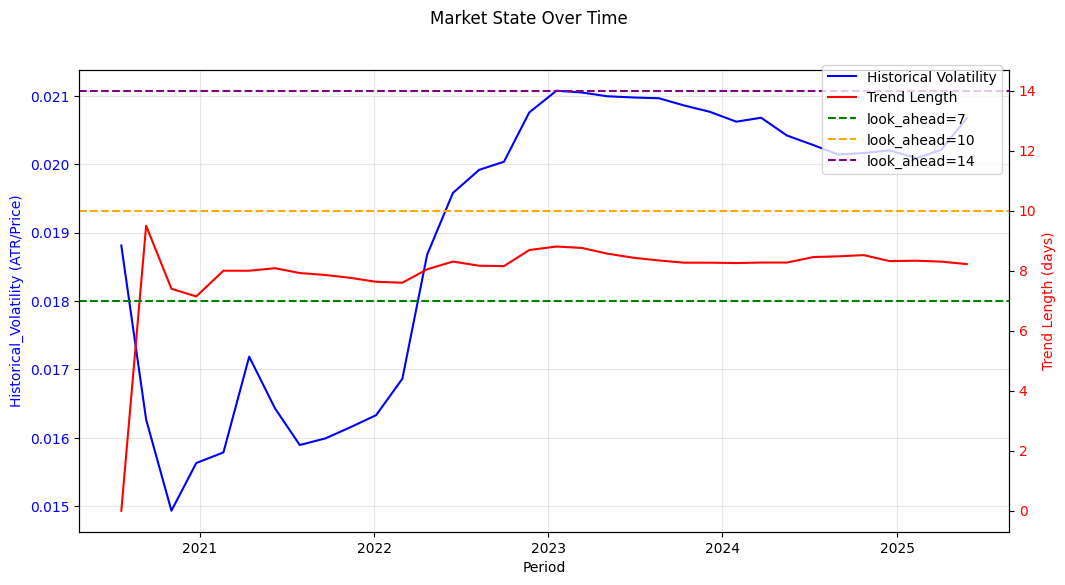

In [87]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from hyperopt import hp, fmin, tpe, Trials
from IPython.display import display
from statsmodels.tsa.stattools import acf
from scipy.signal import periodogram
import os

# 设置随机种子
random_seed = 42  # 可以选择任意整数（如 42、2025 等）
np.random.seed(random_seed)
random.seed(random_seed)

# 数据文件路径
data_dir = '../data'
csv_filename = 'data_US_FXI_20250528_K_DAY.csv'
csv_path = os.path.join(data_dir, csv_filename)

# 读取本地CSV文件
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

# ATR计算（矢量化）
def ATR(high, low, close, period=14):
    tr = pd.DataFrame(index=high.index)
    tr['HL'] = high - low
    tr['HC'] = abs(high - close.shift(1))
    tr['LC'] = abs(low - close.shift(1))
    tr['TR'] = tr[['HL', 'HC', 'LC']].max(axis=1)
    return tr['TR'].rolling(window=int(period), min_periods=1).mean()

# Numba加速未来范围计算
@njit
def get_future_range_numba(series, look_ahead, is_high=True):
    future_values = np.full(len(series), np.nan)
    for i in range(len(series) - look_ahead):
        if is_high:
            future_values[i] = np.max(series[i+1:i+1+look_ahead])
        else:
            future_values[i] = np.min(series[i+1:i+1+look_ahead])
    return future_values

def calculate_trend_duration(df, min_trend_days=5):
    """
    使用均线理论计算趋势长度，以趋势终结日期为索引
    
    参数:
    - min_trend_days: 最小趋势天数
    
    返回:
    - DataFrame包含趋势信息：trend_length, direction
    - 索引为趋势终结日期
    """
    # 计算均线
    df = df.copy()
    df['ma_short'] = df['close'].rolling(window=5).mean()
    df['ma_middle'] = df['close'].rolling(window=10).mean()
    df['ma_long'] = df['close'].rolling(window=15).mean()
    
    trends_data = []
    current_trend = {
        'direction': 0,  # 1: 上升, -1: 下降
        'days': 0,
    }
    
    for i in range(15, len(df)):
        today = df.index[i]
        # 判断趋势方向
        is_uptrend = (df['ma_short'].iloc[i] > df['ma_middle'].iloc[i] > df['ma_long'].iloc[i] and
                     df['ma_short'].iloc[i] > df['ma_short'].iloc[i-1])
        is_downtrend = (df['ma_short'].iloc[i] < df['ma_middle'].iloc[i] < df['ma_long'].iloc[i] and
                       df['ma_short'].iloc[i] < df['ma_short'].iloc[i-1])
        
        if current_trend['direction'] == 0:  # 新趋势开始
            if is_uptrend:
                current_trend = {
                    'direction': 1,
                    'days': 1,
                }
            elif is_downtrend:
                current_trend = {
                    'direction': -1,
                    'days': 1,
                }
        else:  # 已有趋势
            if (current_trend['direction'] == 1 and is_uptrend) or \
               (current_trend['direction'] == -1 and is_downtrend):
                # 趋势继续
                current_trend['days'] += 1
            else:
                # 趋势结束
                if current_trend['days'] >= min_trend_days:
                    trends_data.append({
                        'trend_length': current_trend['days'],
                        'direction': current_trend['direction'],
                        'end_date': today
                    })
                # 重置趋势
                current_trend = {
                    'direction': 0,
                    'days': 0,
                }
    
    # 转换为DataFrame，使用趋势终结日期作为索引
    trends_df = pd.DataFrame(trends_data, index=[trend['end_date'] for trend in trends_data])
    
    # 丢弃首尾趋势
    if len(trends_df) > 2:
        trends_df = trends_df.iloc[1:-1]
    
    return trends_df

# 按时间段分析市场状态
def analyze_market_states(df, period=21):
    df = df.copy()
    # df['date'] = df.index
    group_count = np.ceil(len(df) / period)
    grouped = np.array_split(df, group_count)
    
    volatility = []
    historical_volatility = []
    trend_length = []
    periods = []
    
    # 预先计算全局趋势
    trends_df = calculate_trend_duration(df)
    print(trends_df.describe())
    
    for i, group in enumerate(grouped):
        name = group.index[-1]
        atr = ATR(group['high'], group['low'], group['close'], period=period)
        vol = atr.mean() / group['close'].mean()
        volatility.append(vol)
        
        # 获取当前分组最后一天之前的所有趋势
        group_end = group.index[-1]
        historical_trends = trends_df[trends_df.index <= group_end]['trend_length'].values
        
        # 计算历史趋势长度
        if len(historical_trends) > 0:
            trend_median = np.mean([f for f in historical_trends if f > 0])
            trend_length.append(trend_median)
        else:
            trend_length.append(0)

        historical_volatility.append(np.mean(volatility))
        periods.append(name)
    
    return pd.DataFrame({
        'Period': periods,
        'Volatility': volatility,
        'Historical_Volatility': historical_volatility,
        'Trend_Length': trend_length
    })

# 绘制状态图表
def plot_market_states(df_states):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # 波动性（左轴）
    ax1.plot(df_states['Period'], df_states['Historical_Volatility'], color='blue', label='Historical Volatility')
    ax1.set_xlabel('Period')
    ax1.set_ylabel('Historical_Volatility (ATR/Price)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, alpha=0.3)
    
    # 趋势长度（右轴）
    ax2 = ax1.twinx()
    ax2.plot(df_states['Period'], df_states['Trend_Length'], color='red', label='Trend Length')
    ax2.set_ylabel('Trend Length (days)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # 添加参考线
    ax2.axhline(7, color='green', linestyle='--', label='look_ahead=7')
    ax2.axhline(10, color='orange', linestyle='--', label='look_ahead=10')
    ax2.axhline(14, color='purple', linestyle='--', label='look_ahead=14')
    
    fig.suptitle('Market State Over Time')
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.show()

# 趋势持续时间分布
def plot_trend_duration_distribution(df, smooth_window=5):
    if len(df) <= smooth_window:
        print('df length is less than smooth_window')
        return 0, 0

    trends = calculate_trend_duration(df, smooth_window)
    
    if len(trends) <= 1:
        print('trends length is less than 1')
        return 0, 0
    mean_duration = np.mean(trends['trend_length'].values) 
    median_duration = np.median(trends['trend_length'].values)

    plt.figure(figsize=(10, 6))
    plt.hist(trends['trend_length'], bins=30, color='blue', alpha=0.7, label='Trend Duration Distribution')
    plt.axvline(mean_duration, color='red', linestyle='--', label=f'Mean: {mean_duration:.1f} days')
    plt.axvline(median_duration, color='green', linestyle='--', label=f'Median: {median_duration:.1f} days')
    plt.title(f'Trend Duration Distribution (smooth_window={smooth_window})')
    plt.xlabel('Duration (days)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return mean_duration, median_duration

def determine_look_ahead(volatility, trend_length):
    if volatility > 0.03 and trend_length < 7:
        return 7
    elif volatility < 0.02 and trend_length > 10:
        return 14
    else:
        return 10

def calculate_target_multiplier(df, atr_period=20, look_ahead=10):
    df = df.copy()
    atr = ATR(df['high'], df['low'], df['close'], period=atr_period)
    df['atr'] = atr
    df['future_high'] = get_future_range_numba(df['high'].values, look_ahead, is_high=True)
    df['future_low'] = get_future_range_numba(df['low'].values, look_ahead, is_high=False)
    
    support_returns = (df['future_high'] - df['close']) / df['atr']
    resistance_returns = (df['close'] - df['future_low']) / df['atr']
    valid_returns = pd.concat([support_returns.dropna(), resistance_returns.dropna()])
    
    return np.mean(valid_returns) if len(valid_returns) > 0 else 1.0

def calculate_atr_period(df, max_period=60):
    daily_range = df['high'] - df['low']
    freqs, power = periodogram(daily_range.dropna())
    periods = 1 / freqs
    valid_idx = np.where((periods > 5) & (periods <= max_period))
    dominant_period = periods[valid_idx][np.argmax(power[valid_idx])]
    return int(dominant_period) if dominant_period else 36

def get_signal_target_percentage(volatility):
    if volatility > 0.03:
        return 0.07  # 震荡行情，信号密集
    elif volatility < 0.01:
        return 0.03  # 趋势行情，信号稀疏
    else:
        return 0.05  # 混合行情，适中

# MACD计算
def MACD(close, fast_period, slow_period, signal_period):
    fast_ema = close.ewm(span=fast_period, adjust=False).mean()
    slow_ema = close.ewm(span=slow_period, adjust=False).mean()
    macd = fast_ema - slow_ema
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal

# 主流atr_period
atr_period = calculate_atr_period(df)
# 分析市场状态
df_states = analyze_market_states(df, period=atr_period)
plot_market_states(df_states)
# 最近市场状态
current_state = df_states.iloc[-1]
currnet_look_ahead = determine_look_ahead(current_state['Historical_Volatility'], current_state['Trend_Length'])
look_ahead = currnet_look_ahead # 根据近期Trend Duration Distribution估计
target_multiplier = calculate_target_multiplier(df, atr_period=atr_period, look_ahead=look_ahead)

# 根据市场状态调整目标百分比
signal_target_percentage = get_signal_target_percentage(current_state['Historical_Volatility'])
signal_count_target = len(df) * signal_target_percentage

def detect_macd_signals(df, fast_period=12, slow_period=26, signal_period=9, overbought=10, oversold=-10, mode='train', support_ma_period=10, resistance_ma_period=10):
    df = df.copy()
    macd, signal = MACD(df['close'], fast_period, slow_period, signal_period)
    df['macd'] = macd
    df['signal'] = signal
    # 0轴偏离度
    macd_deviation = 100 * macd/abs(df['close'].ewm(span=fast_period, adjust=False).mean())
    df['macd_deviation'] = macd_deviation

    support_ma = df['close'].rolling(window=int(support_ma_period), min_periods=1).mean()
    resistance_ma = df['close'].rolling(window=int(resistance_ma_period), min_periods=1).mean()

    support_condition = (macd > signal) & (macd.shift(1) <= signal.shift(1)) & (macd_deviation < oversold) & (df['close'] > support_ma)
    resistance_condition = (macd < signal) & (macd.shift(1) >= signal.shift(1)) & (macd_deviation > overbought) & (df['close'] < resistance_ma)
    
    if mode == 'eval':
        # 推理考虑未来阳线
        support_condition = support_condition & (((df['close'].shift(-1) > df['close'])&(df['open'].shift(-1) < df['close'].shift(-1))) | ((df['close'] < df['close'].shift(-2))&(df['close'].shift(-1) < df['close'].shift(-2))))
        resistance_condition = resistance_condition & (((df['close'].shift(-1) < df['close'])&(df['open'].shift(-1) > df['close'].shift(-1))) | ((df['close'] > df['close'].shift(-2))&(df['close'].shift(-1) > df['close'].shift(-2))))
    elif mode == 'train':
        # 训练无未来函数
        pass

    df['reversal'] = np.select(
        [support_condition, resistance_condition],
        ['support reversal', 'resistance reversal'],
        default='none'
    )
    
    # df['is_strong'] = np.where(
    #     (df['reversal'] != 'none') & 
    #     (df['signal_strength'] >= strength_threshold),
    #     1, 0
    # )

    # df['is_strong'] = np.where(
    #     (df['reversal'] != 'none') & 
    #     ((df['macd_deviation'] >= overbought) | (df['macd_deviation'] <= oversold)),
    #     1, 0
    # )

    df['is_strong'] = 1

    return df

def calculate_win_rate(df, look_ahead=10, target_multiplier=1, atr_period=20):
    df = df.copy()
    df['atr'] = ATR(df['high'], df['low'], df['close'], period=atr_period)
    
    df['support_target'] = df['close'] + df['atr'] * target_multiplier
    df['resistance_target'] = df['close'] - df['atr'] * target_multiplier
    
    df['future_high'] = get_future_range_numba(df['high'].values, look_ahead, is_high=True)
    df['future_low'] = get_future_range_numba(df['low'].values, look_ahead, is_high=False)

    df['recent_high'] = df['high'].rolling(window=3, min_periods=1).max()
    df['recent_low'] = df['low'].rolling(window=3, min_periods=1).min()
    
    df['support_win'] = np.where(
        (df['reversal'] == 'support reversal') & (df['future_high'] >= df['support_target']) & (df['recent_low'] <= df['future_low']),
        1, 0
    )
    df['resistance_win'] = np.where(
        (df['reversal'] == 'resistance reversal') & (df['future_low'] <= df['resistance_target']) & (df['recent_high'] >= df['future_high']),
        1, 0
    )
    
    support_signals = df[df['reversal'] == 'support reversal']
    resistance_signals = df[df['reversal'] == 'resistance reversal']
    support_win_rate = support_signals['support_win'].mean() if len(support_signals) > 0 else 0
    resistance_win_rate = resistance_signals['resistance_win'].mean() if len(resistance_signals) > 0 else 0
    
    strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong'] == 1)]
    strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong'] == 1)]
    strong_support_win_rate = strong_support_signals['support_win'].mean() if len(strong_support_signals) > 0 else 0
    strong_resistance_win_rate = strong_resistance_signals['resistance_win'].mean() if len(strong_resistance_signals) > 0 else 0
    
    support_recall = len(strong_support_signals) / len(support_signals) if len(support_signals) > 0 else 0
    resistance_recall = len(strong_resistance_signals) / len(resistance_signals) if len(resistance_signals) > 0 else 0
    
    return {
        'support_win_rate': support_win_rate,
        'support_signals_count': len(support_signals),
        'resistance_win_rate': resistance_win_rate,
        'resistance_signals_count': len(resistance_signals),
        'strong_support_win_rate': strong_support_win_rate,
        'strong_support_signals_count': len(strong_support_signals),
        'strong_resistance_win_rate': strong_resistance_win_rate,
        'strong_resistance_signals_count': len(strong_resistance_signals),
        'support_recall': support_recall,
        'resistance_recall': resistance_recall,
        'detailed_df': df
    }

def plot_signals(result, name=''):
    df_visual = result['detailed_df']
    plt.figure(figsize=(16, 8))
    plt.plot(df_visual.index, df_visual['close'], label='Close Price', color='blue', alpha=0.5)

    # 强信号
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 1) & (df_visual['support_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 1) & (df_visual['support_win'] == 1)]['close'],
                color='darkgreen', marker='o', label='Strong Support (Win)', s=100)
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 1) & (df_visual['support_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 1) & (df_visual['support_win'] == 0)]['close'],
                color='lightgreen', marker='o', label='Strong Support (Lose)', s=100)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 1) & (df_visual['resistance_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 1) & (df_visual['resistance_win'] == 1)]['close'],
                color='darkred', marker='s', label='Strong Resistance (Win)', s=100)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 1) & (df_visual['resistance_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 1) & (df_visual['resistance_win'] == 0)]['close'],
                color='salmon', marker='s', label='Strong Resistance (Lose)', s=100)

    # 弱信号（淡化显示）
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 1)]['close'],
                color='darkgreen', marker='o', label='Weak Support (Win)', s=30, alpha=0.3)
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 0)]['close'],
                color='lightgreen', marker='o', label='Weak Support (Lose)', s=30, alpha=0.3)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 1)]['close'],
                color='darkred', marker='s', label='Weak Resistance (Win)', s=30, alpha=0.3)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 0)]['close'],
                color='salmon', marker='s', label='Weak Resistance (Lose)', s=30, alpha=0.3)

    # 增强标题信息
    title = (
        f'{name} MACD Signals\n'
        f'Strong Support Win Rate: {result["strong_support_win_rate"]:.2%} (Signals: {result["strong_support_signals_count"]})\n'
        f'Strong Resistance Win Rate: {result["strong_resistance_win_rate"]:.2%} (Signals: {result["strong_resistance_signals_count"]})\n'
        f'Support Win Rate: {result["support_win_rate"]:.2%}\n'
        f'Resistance Win Rate: {result["resistance_win_rate"]:.2%}\n'
        f'Support Recall: {result["support_recall"]:.2%}\n'
        f'Resistance Recall: {result["resistance_recall"]:.2%}'
    )
    plt.title(title, fontsize=12)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.show()

def run_bayes_optimization(space, objective, max_evals=400, patience=20, min_delta=0.001, random_seed=None):
    """运行贝叶斯优化"""
    if random_seed is not None:
        np.random.seed(random_seed)
        random.seed(random_seed)
    
    trials = Trials()
    best_score = float('-inf')
    no_improvement_count = 0
    
    def early_stop_fn(trials):
        nonlocal best_score, no_improvement_count
        
        # 获取当前最佳分数
        current_score = -trials.best_trial['result']['loss']
        
        # 检查是否有显著改善
        if current_score > best_score + min_delta:
            best_score = current_score
            no_improvement_count = 0
            return False, {}  # 返回元组 (stop, kwargs)
        
        # 无显著改善，增加计数
        no_improvement_count += 1
        
        # 如果连续多代无改善，触发早停
        if no_improvement_count >= patience:
            return True, {}  # 返回元组 (stop, kwargs)
        
        return False, {}  # 返回元组 (stop, kwargs)
    
    # 执行贝叶斯优化
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        early_stop_fn=early_stop_fn,
        verbose=False
    )
    
    return best, trials

Train

In [88]:
from hyperopt import hp
space = {
    'fast_period': hp.quniform('fast_period', 5, 24, 1),
    'slow_period': hp.quniform('slow_period', 13, 52, 1),
    'signal_period': hp.quniform('signal_period', 5, 18, 1),
    'overbought': hp.quniform('overbought', 1, 10, 1),
    'oversold': hp.quniform('oversold', -10, 1, 1),
    'support_ma_period': hp.quniform('support_ma_period', 5, 60, 5),
    'resistance_ma_period': hp.quniform('resistance_ma_period', 5, 60, 5),
    # 'strength_threshold': hp.quniform('strength_threshold', 0.0, 5, 0.5),
}

In [89]:

# 目标函数，调整优化目标以保留更多信号
def objective(params):
    # 转换为整数值
    params_int = {
        'fast_period': int(params['fast_period']),
        'slow_period': int(params['slow_period']),
        'signal_period': int(params['signal_period']),
        'overbought': params['overbought'],
        'oversold': params['oversold'],
        'support_ma_period': int(params['support_ma_period']),
        'resistance_ma_period': int(params['resistance_ma_period']),
        # 'strength_threshold': params['strength_threshold']
    }
    df_with_signals = detect_macd_signals(df.copy(), mode='train',**params_int)
    # df_with_signals = detect_stochastic_signals(df.copy(), mode='train',**params_int)
    result = calculate_win_rate(df_with_signals, look_ahead=look_ahead, target_multiplier=target_multiplier, atr_period=atr_period)
    
    # 计算F2得分（β=2，更重视召回率）
    # beta = 2
    # support_precision = result['strong_support_win_rate']
    # support_recall = result['support_recall']
    # resistance_precision = result['strong_resistance_win_rate']
    # resistance_recall = result['resistance_recall']
    
    # support_f2 = (1 + beta**2) * (support_precision * support_recall) / (beta**2 * support_precision + support_recall) if (support_precision + support_recall) > 0 else 0
    # resistance_f2 = (1 + beta**2) * (resistance_precision * resistance_recall) / (beta**2 * resistance_precision + resistance_recall) if (resistance_precision + resistance_recall) > 0 else 0
    # score = (support_f2 + resistance_f2) / 2

    support_f1 = 2 * (result['strong_support_win_rate'] * result['support_recall']) / (result['strong_support_win_rate'] + result['support_recall']) if (result['strong_support_win_rate'] + result['support_recall']) > 0 else 0
    resistance_f1 = 2 * (result['strong_resistance_win_rate'] * result['resistance_recall']) / (result['strong_resistance_win_rate'] + result['resistance_recall']) if (result['strong_resistance_win_rate'] + result['resistance_recall']) > 0 else 0
    # score = (support_f1 + resistance_f1) / 2
    if support_f1 > 0 and resistance_f1 > 0:
        # 普通调和平均数
        score = 2 / (1/support_f1 + 1/resistance_f1)
        # 加权调和平均数
        # weight_support = 1 / support_f1
        # weight_resistance = 1 / resistance_f1
        # total_weight = weight_support + weight_resistance
        # score = total_weight / (weight_support/support_f1 + weight_resistance/resistance_f1)
    else:
        score = 0
    
    # 添加信号数量惩罚项
    signal_count_penalty = min(1.0, min(result['strong_support_signals_count'], result['strong_resistance_signals_count']) / signal_count_target)
    adjusted_score = score * signal_count_penalty
    
    return -adjusted_score  # 负值用于最小化

In [90]:
# 执行贝叶斯优化
# 主优化循环
scores = []
best_params = []
n_optimizations = 20  # 优化次数

for i in range(n_optimizations):
    random_seed = np.random.randint(0, 1000000)
    
    # 运行带早停的贝叶斯优化
    best, trials = run_bayes_optimization(
        space=space,
        objective=objective,
        max_evals=500,
        patience=100,
        min_delta=0.001,
        random_seed=random_seed
    )
    
    score = -trials.best_trial['result']['loss']
    scores.append(score)
    best_params.append(best)
    
    print(f"{i+1}/{n_optimizations} score: {score:.4f} evals: {len(trials.trials)}")

# 分析结果
best_idx = np.argmax(scores)
print("\n优化完成!")
print(f"最佳分数: {scores[best_idx]:.4f}")
print(f"最佳参数: {best_params[best_idx]}")

best = best_params[best_idx]


1/20 score: 0.1668 evals: 254
2/20 score: 0.2434 evals: 358
3/20 score: 0.0000 evals: 101
4/20 score: 0.1319 evals: 235
5/20 score: 0.2422 evals: 367
6/20 score: 0.2368 evals: 297
7/20 score: 0.1246 evals: 189
8/20 score: 0.2878 evals: 500
9/20 score: 0.1976 evals: 246
10/20 score: 0.1305 evals: 131
11/20 score: 0.1708 evals: 128
12/20 score: 0.2173 evals: 368
13/20 score: 0.2199 evals: 270
14/20 score: 0.2338 evals: 390
15/20 score: 0.2315 evals: 281
16/20 score: 0.2115 evals: 253
17/20 score: 0.2343 evals: 364
18/20 score: 0.1374 evals: 251
19/20 score: 0.1408 evals: 273
20/20 score: 0.1399 evals: 249

优化完成!
最佳分数: 0.2878
最佳参数: {'fast_period': 5.0, 'overbought': 1.0, 'oversold': -0.0, 'resistance_ma_period': 5.0, 'signal_period': 5.0, 'slow_period': 28.0, 'support_ma_period': 10.0}


In [91]:
# 将best参数转换为实际值
best_params = {
    'fast_period': int(best['fast_period']),
    'slow_period': int(best['slow_period']),
    'signal_period': int(best['signal_period']),
    'overbought': best['overbought'],
    'oversold': best['oversold'],
    'support_ma_period': int(best['support_ma_period']),
    'resistance_ma_period': int(best['resistance_ma_period']),
    # 'strength_threshold': best['strength_threshold']
}

Checked signals

Support Reversal for data_US_FXI_20250528_K_DAY.csv:
Current Market State: 2025-05-27 00:00:00-04:00
Current Market State Volatility: 0.020673011325183288
Current Market signal target percentage: 5.0%
Recommended look_ahead for 2025-05-27 00:00:00-04:00: 10 days
Pre-calculated: look_ahead=10, target_multiplier=1.98, atr_period=38
Best Parameters: {'fast_period': 5, 'slow_period': 28, 'signal_period': 5, 'overbought': 1.0, 'oversold': -0.0, 'support_ma_period': 10, 'resistance_ma_period': 5}
Overall Support Reversal Win Rate: 50.00% (Signals: 22)
Overall Resistance Reversal Win Rate: 33.33% (Signals: 15)
Strong Support Reversal Win Rate: 50.00% (Signals: 22)
Strong Resistance Reversal Win Rate: 33.33% (Signals: 15)
Support Recall: 100.00%
Resistance Recall: 100.00%


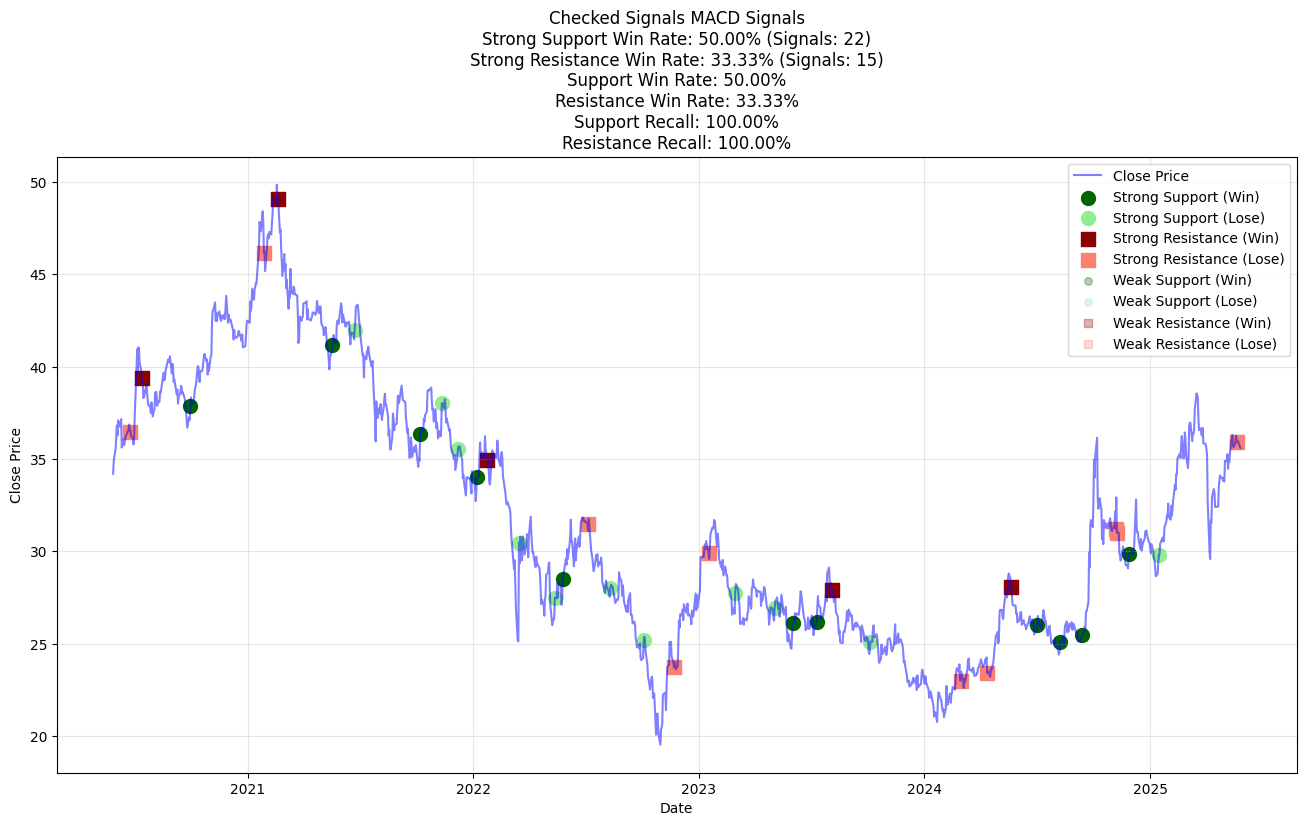

In [92]:
# 使用最佳参数计算最终信号
df = detect_macd_signals(df,mode='eval', **best_params)
# df = detect_stochastic_signals(df,mode='eval', **best_params)
result = calculate_win_rate(df, look_ahead=look_ahead, target_multiplier=target_multiplier, atr_period=atr_period)

# 输出结果
# display(df_states.tail(12))
print(f"Support Reversal for {csv_filename}:")
print(f"Current Market State: {current_state['Period']}")
print(f"Current Market State Volatility: {current_state['Historical_Volatility']}")
print(f"Current Market signal target percentage: {signal_target_percentage*100}%")
print(f"Recommended look_ahead for {current_state['Period']}: {currnet_look_ahead} days")
print(f"Pre-calculated: look_ahead={look_ahead}, target_multiplier={target_multiplier:.2f}, atr_period={atr_period}")
print(f"Best Parameters: {best_params}")
print(f"Overall Support Reversal Win Rate: {result['support_win_rate']:.2%} (Signals: {result['support_signals_count']})")
print(f"Overall Resistance Reversal Win Rate: {result['resistance_win_rate']:.2%} (Signals: {result['resistance_signals_count']})")
print(f"Strong Support Reversal Win Rate: {result['strong_support_win_rate']:.2%} (Signals: {result['strong_support_signals_count']})")
print(f"Strong Resistance Reversal Win Rate: {result['strong_resistance_win_rate']:.2%} (Signals: {result['strong_resistance_signals_count']})")
print(f"Support Recall: {result['support_recall']:.2%}")
print(f"Resistance Recall: {result['resistance_recall']:.2%}")


plot_signals(result,'Checked Signals')

Origin Signals

Support Reversal for orignal data_US_FXI_20250528_K_DAY.csv:
Current Market State: 2025-05-27 00:00:00-04:00
Current Market State Volatility: 0.03601652407612933
Current Market signal target percentage: 5.0%
Recommended look_ahead for 2025-05-27 00:00:00-04:00: 10 days
Pre-calculated: look_ahead=10, target_multiplier=1.98, atr_period=38
Best Parameters: {'fast_period': 5, 'slow_period': 28, 'signal_period': 5, 'overbought': 1.0, 'oversold': -0.0, 'support_ma_period': 10, 'resistance_ma_period': 5}
Overall Support Reversal Win Rate: 37.14% (Signals: 35)
Overall Resistance Reversal Win Rate: 35.29% (Signals: 34)
Strong Support Reversal Win Rate: 37.14% (Signals: 35)
Strong Resistance Reversal Win Rate: 35.29% (Signals: 34)
Support Recall: 100.00%
Resistance Recall: 100.00%


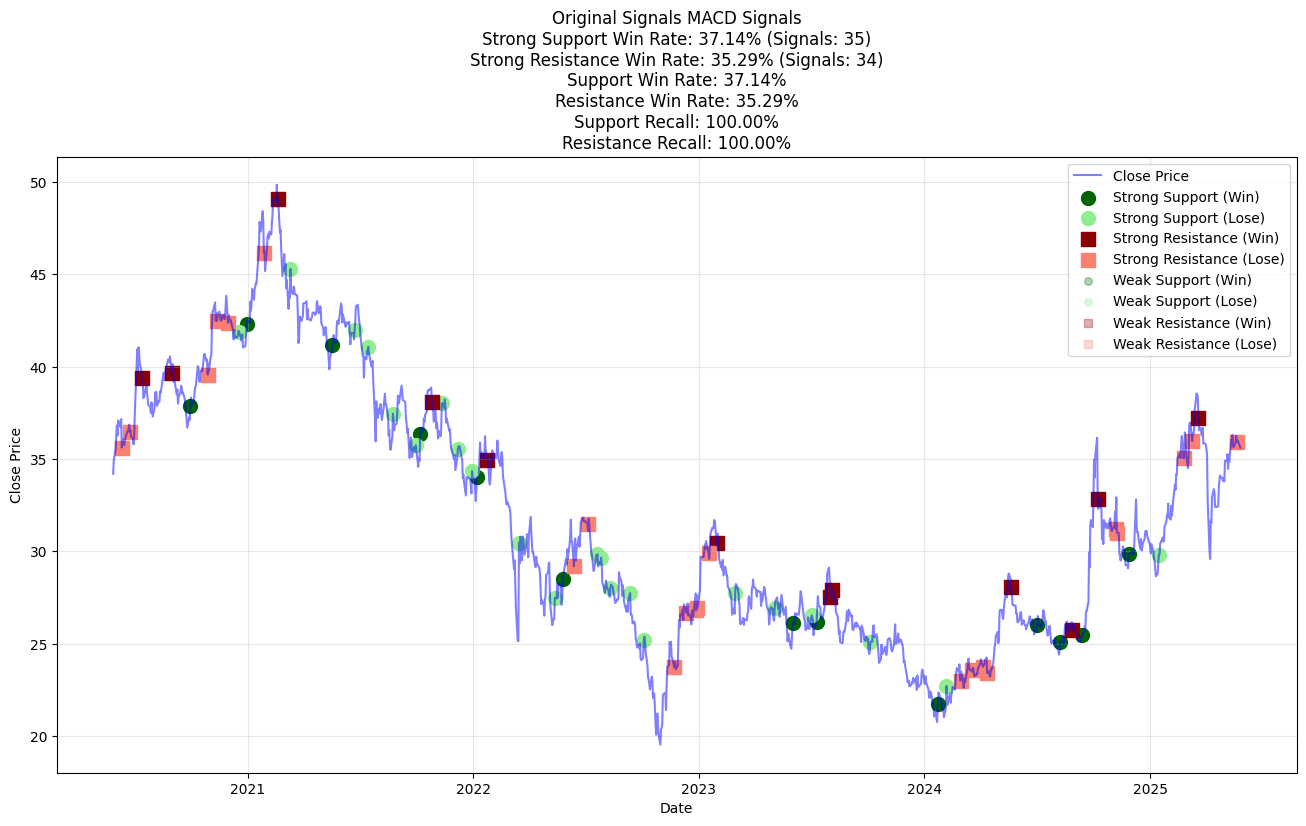

In [93]:
# 使用最佳参数计算最终信号
df_original = detect_macd_signals(df,mode='train', **best_params)
# df_original = detect_stochastic_signals(df,mode='train', **best_params)
result_original = calculate_win_rate(df_original, look_ahead=look_ahead, target_multiplier=target_multiplier, atr_period=atr_period)

# 输出结果
# display(df_states.tail(12))
print(f"Support Reversal for orignal {csv_filename}:")
print(f"Current Market State: {current_state['Period']}")
print(f"Current Market State Volatility: {current_state['Volatility']}")
print(f"Current Market signal target percentage: {signal_target_percentage*100}%")
print(f"Recommended look_ahead for {current_state['Period']}: {currnet_look_ahead} days")
print(f"Pre-calculated: look_ahead={look_ahead}, target_multiplier={target_multiplier:.2f}, atr_period={atr_period}")
print(f"Best Parameters: {best_params}")
print(f"Overall Support Reversal Win Rate: {result_original['support_win_rate']:.2%} (Signals: {result_original['support_signals_count']})")
print(f"Overall Resistance Reversal Win Rate: {result_original['resistance_win_rate']:.2%} (Signals: {result_original['resistance_signals_count']})")
print(f"Strong Support Reversal Win Rate: {result_original['strong_support_win_rate']:.2%} (Signals: {result_original['strong_support_signals_count']})")
print(f"Strong Resistance Reversal Win Rate: {result_original['strong_resistance_win_rate']:.2%} (Signals: {result_original['strong_resistance_signals_count']})")
print(f"Support Recall: {result_original['support_recall']:.2%}")
print(f"Resistance Recall: {result_original['resistance_recall']:.2%}")
plot_signals(result_original,'Original Signals')

In [94]:
# 将原始DataFrame保存为CSV文件
# csv_path = '../data/stochastic_signals_optimized.csv'
# result_original['detailed_df'].to_csv(csv_path, index=True)
# print(f"\nDetailed DataFrame saved to: {csv_path}")